# Install geopy
the library is needed for determination of a true nearest neighbor observation

In [1]:
! pip3 install geopy

# Importing necessary libraries

In [2]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data

import os
import sys

import getpass

import numpy as np

import matplotlib.pyplot as plt # needed to plot the resulting time series
from matplotlib.pyplot import cm
from datetime import datetime, timedelta, timezone # needed to work with time in plotting time series

import cmr
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

import geopy.distance as geodist

# Define a function to read FLX data
## this function reads both original granules and subset
## though the outputs have different dimensions due to different file structure of original and subset data files

In [3]:
def read_PREFIRE_2B_FLX(fn):

  try:
    ds = nc.Dataset(fn)
    geo = ds.groups['Geometry']

    var = geo.variables['ctime']
    ctime = np.ma.getdata(var[:])

    var = geo.variables['ctime_minus_UTC']
    ctime_minus_UTC = np.ma.getdata(var[:])

    var = geo.variables['latitude']
    lat = np.ma.getdata(var[:])

    var = geo.variables['longitude']
    lon = np.ma.getdata(var[:])

    var = geo.variables['time_UTC_values']
    time_UTC = np.ma.getdata(var[:])

    Flx = ds.groups['Flx']
    var = Flx.variables['flx_qc_bitflags']
    flxbitQF = np.ma.getdata(var[:])

    var = Flx.variables['flx_quality_flag']
    flxQF = np.ma.getdata(var[:])

    var = Flx.variables['olr']
    olr = np.ma.getdata(var[:])
    fv_olr = var.get_fill_value()
    olr_unit = var.getncattr('units')

    ds.close()

  except:
    ctime = 0.
    ctime_minus_UTC = 0.
    lat = 0.
    lon = 0.
    time_UTC = 0.
    flxbitQF = 0.
    flxQF = 0.
    olr = 0.
    fv_olr = 0.
    olr_unit = 0.

  return ctime, ctime_minus_UTC, lat, lon, time_UTC\
, flxbitQF, flxQF, olr, fv_olr, olr_unit

# Set name constants

In [4]:
out_Q = 'OLR'
out_Q_unit = 'W m-2'

# Logging in with Earthdata credentials

In [5]:
#User needs to create an account at https://www.earthdata.nasa.gov/
#Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

# Define a function to obtain collection ID
## collection ID will be needed for accessing the collection with Harmony-py

In [6]:
def get_collectionID_earthaccess(short_name, version):
    collectionID = '-1'

    results = earthaccess.search_datasets(short_name=short_name, version=version)

    if len(results)==1: collectionID = results[0]['meta']['concept-id']
    else: raise Exception('Specify valid collection')

    return collectionID

In [7]:
short_name = 'PREFIRE_SAT2_2B-FLX'
version = 'R01'
collectionID = get_collectionID_earthaccess(short_name, version)
print(f"collectionID for collection short_name {short_name} and version {version} is {collectionID}")

collectionID for collection short_name PREFIRE_SAT2_2B-FLX and version R01 is C3499202317-LARC_CLOUD


# Search for all granules covering point of interest (POI)

## Set POI
Edge Island, Svalbard, Norway

In [8]:
POI_name = 'Svalbard'
[POI_lon, POI_lat] =  [22.5, 77.75]
POI = [POI_lon, POI_lat]
# POI location string for output files
if POI_lon < 0.: lon_str = str('%08.4fW' %(-POI_lon))
else: lon_str = str('%08.4fE' %(POI_lon))
if POI_lat < 0.: lat_str = str('%08.4fS' %(-POI_lat))
else: lat_str = str('%08.4fN' %(POI_lat))
POI_loc_str = POI_name + '_' + lat_str + '_' + lon_str
print(POI_loc_str)

Svalbard_077.7500N_022.5000E


## Search for granules through entire mission lifetime

In [9]:
short_name = 'PREFIRE_SAT2_2B-FLX' # collection name
version = 'R01' # version of the collection

results_earthaccess = earthaccess.search_data(short_name = short_name\
                                , version = version\
                                , point = (POI_lon, POI_lat)) # longitude-latitude pair

PREFIRE_names = sorted([r['meta']['native-id'] for r in results_earthaccess])
print(len(PREFIRE_names), "granules were found")

344 granules were found


# Logging in with Harmony-py

In [10]:
print('Please provide your Earthdata Login credentials to allow data access')
print('Your credentials will only be passed to Earthdata and will not be exposed in the notebook')
username = input('Username:')

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to Earthdata and will not be exposed in the notebook


Username: alexrad71
 ········


# Define function creating Harmony-py request and returning job ID

In [11]:
def create_Harmony_job_id(filenames, collectionID, POI_lon, POI_lat):
# function create_Harmony_job_id takes a list of granule names to subset, filenames,
#                                      a collection ID,
#                                  and a position of the POI.
# the list of variables to retain is pre-defined
    request = Request(collection=Collection(id=collectionID)
                    , granule_name=filenames
                    , variables=['Geometry/ctime'
                               , 'Geometry/ctime_minus_UTC'
                               , 'Geometry/latitude'
                               , 'Geometry/longitude'
                               , 'Geometry/time_UTC_values'
                               , 'Flx/flx_qc_bitflags'
                               , 'Flx/flx_quality_flag'
                               , 'Flx/olr']
# subsetting in space around the POI
                    , spatial = BBox(POI_lon - .5, POI_lat - .5, POI_lon + .5, POI_lat + .5))
    assert request.is_valid()
    job_id = harmony_client.submit(request)

    return job_id

# Search and download subset data
### un-documented "feature" of Request function used in the function definition above is that
### the length of the list granules is limited. It is somewhere between 75 and 100.
### We have to split a longer list into parts.

In [12]:
chunk_size = 75
num_files = len(PREFIRE_names)
print(num_files)
all_filenames = []*num_files
all_filenames[:] = PREFIRE_names[:]

job_id_list = []
i = 0
while len(all_filenames) > chunk_size:
    chunk = all_filenames[:chunk_size]
#    print(chunk)
    del all_filenames[:chunk_size]
    job_id = create_Harmony_job_id(chunk, collectionID, POI_lon, POI_lat)
    job_id_list.append(job_id)
    i = i + 1
    print('chunk ', i, ' job_id:', job_id)

last_chunk = all_filenames
last_job_id = create_Harmony_job_id(last_chunk, collectionID, POI_lon, POI_lat)
print('chunk ', i+1, ' job_id:', last_job_id)
job_id_list.append(last_job_id)

print(len(PREFIRE_names))
print(len(all_filenames))

all_results_stored = []
for job_id in job_id_list:
    print(f'jobID = {job_id}')
    harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
    results = harmony_client.download_all(job_id, directory='./', overwrite=True)
    all_results_stored.append([f.result() for f in results])

print(len(all_results_stored))
fout = open('subset_names.txt', 'w')
for result in all_results_stored:
    for res in result: fout.write(res+'\n')

fout.close()

344
chunk  1  job_id: 576a333e-11d5-4b04-83d3-28290231078e
chunk  2  job_id: 8d657e5d-4093-436e-83a6-babf0edaf33f
chunk  3  job_id: 1cfb7896-aaa0-4a27-90dd-500a13198959
chunk  4  job_id: 49dcb55d-263b-444f-bbc4-6e840e06fb45


 [ Processing:   0% ] |                                                   | [/]

chunk  5  job_id: 887d50ba-2c5a-4b76-99ad-f9925009f1f4
344
44
jobID = 576a333e-11d5-4b04-83d3-28290231078e


 [ Processing: 100% ] |###################################################| [|]


./101597224_PREFIRE_SAT2_2B-FLX_R01_P00_20240630033949_00541_subsetted_20240831T032430Z_C3499202317-LARC_CLOUD_merged.nc4
jobID = 8d657e5d-4093-436e-83a6-babf0edaf33f


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

./101597223_PREFIRE_SAT2_2B-FLX_R01_P00_20240831205207_01489_subsetted_20241109T210231Z_C3499202317-LARC_CLOUD_merged.nc4
jobID = 1cfb7896-aaa0-4a27-90dd-500a13198959


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

./101597221_PREFIRE_SAT2_2B-FLX_R01_P00_20241110032306_02552_subsetted_20250114T031335Z_C3499202317-LARC_CLOUD_merged.nc4
jobID = 49dcb55d-263b-444f-bbc4-6e840e06fb45


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

./101597222_PREFIRE_SAT2_2B-FLX_R01_P00_20250114203927_03547_subsetted_20250327T032736Z_C3499202317-LARC_CLOUD_merged.nc4
jobID = 887d50ba-2c5a-4b76-99ad-f9925009f1f4


 [ Processing: 100% ] |###################################################| [|]


./101597219_PREFIRE_SAT2_2B-FLX_R01_P00_20250327205240_04638_subsetted_20250509T033927Z_C3499202317-LARC_CLOUD_merged.nc4
5
./101597654_PREFIRE_SAT2_2B-FLX_R01_P00_20240630002914_00539_subsetted_20240915T003053Z_C3499202317-LARC_CLOUD_merged.nc4
./101597663_PREFIRE_SAT2_2B-FLX_R01_P00_20240915082659_01708_subsetted_20241214T083928Z_C3499202317-LARC_CLOUD_merged.nc4
./101597653_PREFIRE_SAT2_2B-FLX_R01_P00_20241215003034_03080_subsetted_20250318T085053Z_C3499202317-LARC_CLOUD_merged.nc4
./101597652_PREFIRE_SAT2_2B-FLX_R01_P00_20250319004104_04504_subsetted_20250509T002931Z_C3499202317-LARC_CLOUD_merged.nc4


# Create timeseries of OLR
### clear and cloudy retrievals are separated by quality flag
### nearest neighbor are limited to be less than 25 km avay from the POI, see  figures of atrack and xtrack distances distributions below.
![](atrack_dist.png)
![](xtrack_dist.png)

In [13]:
# read subset file names back
fin = open('subset_names.txt', 'r')
subset_filenames = fin.readlines()
fin.close()

fout_HQ_clear = open(out_Q+'_clear_'+ POI_loc_str, 'w')
fout_HQ_clear.write('timeseries of clear'+out_Q+' at '+POI_loc_str+'\n')
fout_HQ_clear.write('YYYY MM DD hh mm ss  ms     lat      lon olr,'+out_Q_unit+' dist_to_POI\n')

fout_HQ_cloudy = open(out_Q+'_cloudy_'+ POI_loc_str, 'w')
fout_HQ_cloudy.write('timeseries of cloudy'+out_Q+' at '+POI_loc_str+'\n')
fout_HQ_cloudy.write('YYYY MM DD hh mm ss  ms     lat      lon olr,'+out_Q_unit+' dist_to_POI\n')

for fn in subset_filenames:
    fname = fn.split('/')[-1][:-1] # the subsets are in local directory, so we need only file name, .split('/')[-1] removes path, [:-1] remove "new line" at the end
    print(fname)
    ctime, ctime_minus_UTC, lat, lon, time_UTC\
, flxbitQF, flxQF, olr, fv_olr, olr_unit =  read_PREFIRE_2B_FLX(fname)
# subset files are comprised of multiple granule subsets, check the number of granules contributing to the subset file
    ngranules = ctime.shape[0]

    for igranule in range(ngranules):
        mask_hq = (olr[igranule] != fv_olr)&(flxbitQF[igranule] == 0)

# search for clear-sky observations
        mask_clear = mask_hq&(flxQF[igranule] == 0)
        lat_clear = lat[igranule, mask_clear]
        lon_clear = lon[igranule, mask_clear]
        olr_clear = olr[igranule, mask_clear]
        nclear = len(lat_clear)
        if nclear > 0:
            dist_clear = np.empty(nclear)
            for i, (lat_loc, lon_loc) in enumerate(zip(lat_clear, lon_clear)):
                dist_clear[i] = geodist.geodesic((POI_lat, POI_lon), (lat_loc, lon_loc)).km

            olr_clear_to_sort = np.stack((lat_clear, lon_clear, olr_clear, dist_clear), axis = 1)
            olr_clear_sorted = olr_clear_to_sort[olr_clear_to_sort[:, 3].argsort()]
            if olr_clear_sorted[0, 3]<=25.: # check whether the nearest pixel is within 25 km from the POI
                atrack_index_clear = np.argwhere(lat[igranule] == olr_clear_sorted[0, 0])[0, 0]
                time_clear = time_UTC[igranule, atrack_index_clear]
                fout_HQ_clear.write(f'{time_clear[0]:4d} {time_clear[1]:2d} {time_clear[2]:2d} {time_clear[3]:2d} {time_clear[4]:2d} {time_clear[5]:2d} {time_clear[6]:3d}')
                fout_HQ_clear.write(f'{olr_clear_sorted[0, 0]:8.4f} {olr_clear_sorted[0, 1]:8.4f} {olr_clear_sorted[0, 2]:8.4f} {olr_clear_sorted[0, 3]:8.4f}\n')

# search for cloudy observations
        mask_cloudy = mask_hq&(flxQF[igranule] == 1)
        lat_cloudy = lat[igranule, mask_cloudy]
        lon_cloudy = lon[igranule, mask_cloudy]
        olr_cloudy = olr[igranule, mask_cloudy]
        ncloudy = len(lat_cloudy)
        if ncloudy > 0:
            dist_cloudy = np.empty(ncloudy)
            for i, (lat_loc, lon_loc) in enumerate(zip(lat_cloudy, lon_cloudy)):
                dist_cloudy[i] = geodist.geodesic((POI_lat, POI_lon), (lat_loc, lon_loc)).km

            olr_cloudy_to_sort = np.stack((lat_cloudy, lon_cloudy, olr_cloudy, dist_cloudy), axis = 1)
            olr_cloudy_sorted = olr_cloudy_to_sort[olr_cloudy_to_sort[:, 3].argsort()]
            if olr_cloudy_sorted[0, 3]<=25.: # check whether the nearest pixel is within 25 km from the POI
                atrack_index_cloudy = np.argwhere(lat[igranule] == olr_cloudy_sorted[0, 0])[0, 0]
                time_cloudy = time_UTC[igranule, atrack_index_cloudy]
                fout_HQ_cloudy.write(f'{time_cloudy[0]:4d} {time_cloudy[1]:2d} {time_cloudy[2]:2d} {time_cloudy[3]:2d} {time_cloudy[4]:2d} {time_cloudy[5]:2d} {time_cloudy[6]:3d}')
                fout_HQ_cloudy.write(f'{olr_cloudy_sorted[0, 0]:8.4f} {olr_cloudy_sorted[0, 1]:8.4f} {olr_cloudy_sorted[0, 2]:8.4f} {olr_cloudy_sorted[0, 3]:8.4f}\n')

fout_HQ_clear.close()
fout_HQ_cloudy.close()

101597224_PREFIRE_SAT2_2B-FLX_R01_P00_20240630033949_00541_subsetted_20240831T032430Z_C3499202317-LARC_CLOUD_merged.nc4
101597223_PREFIRE_SAT2_2B-FLX_R01_P00_20240831205207_01489_subsetted_20241109T210231Z_C3499202317-LARC_CLOUD_merged.nc4
101597221_PREFIRE_SAT2_2B-FLX_R01_P00_20241110032306_02552_subsetted_20250114T031335Z_C3499202317-LARC_CLOUD_merged.nc4
101597222_PREFIRE_SAT2_2B-FLX_R01_P00_20250114203927_03547_subsetted_20250327T032736Z_C3499202317-LARC_CLOUD_merged.nc4
101597219_PREFIRE_SAT2_2B-FLX_R01_P00_20250327205240_04638_subsetted_20250509T033927Z_C3499202317-LARC_CLOUD_merged.nc4


# define a function to read written down timeseries

In [14]:
def read_timeseries(ts_fname, yyyy_ini, mm_ini, dd_ini):

    fout = open(ts_fname, 'r')

    header1 = fout.readline()
    header2 = fout.readline()
    data_lines = fout.readlines()

    fout.close()

    hh = 0
    mm = 0
    ss = 0
    dt0 = datetime(yyyy_ini, mm_ini, dd_ini, hh, mm, ss, tzinfo=timezone.utc)

    time_series = np.empty([0, 2])

    for line in data_lines:
        split = line.split()
        YYYY = int(split[0])
        MM = int(split[1])
        DD = int(split[2])
        hh = int(split[3])
        mm = int(split[4])
        ss = int(split[5])
        ms = int(split[6])
        if ms > 999: ms = 999
        olr = float(split[9])
        obs_time = datetime(YYYY, MM, DD, hh, mm, ss, ms*1000, tzinfo=timezone.utc)
# dt below is time since the beginning of the period of interest in days
        dt = (obs_time - dt0).total_seconds()/86400.
        time_series = np.append(time_series, [[dt, olr]], axis = 0)

    return time_series, dt0

# Read timeseries back

In [15]:
fname_clear = out_Q+'_clear_'+ POI_loc_str
fname_cloudy = out_Q+'_cloudy_'+ POI_loc_str

yyyy_ini = 2024
mm_ini = 6
dd_ini = 30

time_series_clear, dt0 = read_timeseries(fname_clear, yyyy_ini, mm_ini, dd_ini)
time_series_cloudy, dt0 = read_timeseries(fname_cloudy, yyyy_ini, mm_ini, dd_ini)

# Plot timeseries

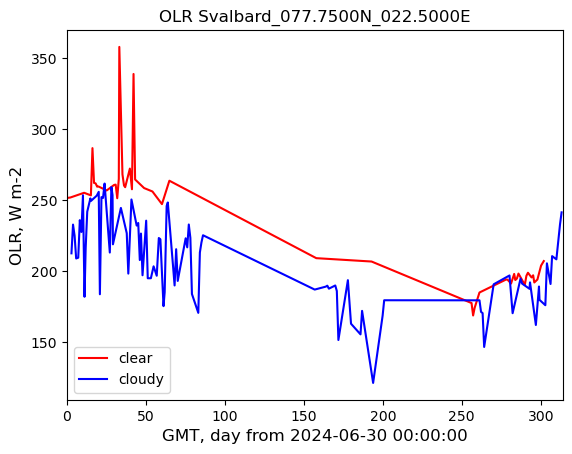

In [16]:
plot_title = out_Q+' '+POI_loc_str
img_name = out_Q+'_'+POI_loc_str+'.jpg'

plt.plot(time_series_clear[:, 0], time_series_clear[:, 1],\
         label = "clear", c = 'r')
plt.plot(time_series_cloudy[:, 0], time_series_cloudy[:, 1],
         label = "cloudy", c = 'b')

# Set the range of x-axis
l_lim = 0.
u_lim = np.ceil(max(time_series_clear[-1,0], time_series_cloudy[-1,0])) 
plt.xlim(l_lim, u_lim)

# some research is required to set the vertical range
plt.xlabel(r'GMT, day from '+dt0.strftime('%Y-%m-%d %H:%M:%S'), fontsize=12)
plt.ylabel('OLR, '+olr_unit, fontsize=12)

plt.legend(loc='lower left')

plt.title(plot_title)
plt.savefig(img_name, format='jpg', dpi=300)

## Set another POI
Dome C, Antarctica

In [17]:
#  POI: Dome C, Antarctica
#Coordinates: 75°05′59″S 123°19′56″E
POI_lat = -(75 + 5/60. + 59/3600.)
POI_lon = 123 + 19/60. + 56/3600.

POI_name = 'Dome_C'
# POI location string for output files
if POI_lon < 0.: lon_str = str('%08.4fW' %(-POI_lon))
else: lon_str = str('%08.4fE' %(POI_lon))
if POI_lat < 0.: lat_str = str('%08.4fS' %(-POI_lat))
else: lat_str = str('%08.4fN' %(POI_lat))
POI_loc_str = POI_name + '_' + lat_str + '_' + lon_str
print(POI_loc_str)

Dome_C_075.0997S_123.3322E


## Search for granules through entire mission lifetime

In [18]:
short_name = 'PREFIRE_SAT2_2B-FLX' # collection name
version = 'R01' # version of the collection

results_earthaccess = earthaccess.search_data(short_name = short_name\
                                , version = version\
                                , point = (POI_lon, POI_lat)) # longitude-latitude pair

PREFIRE_names = sorted([r['meta']['native-id'] for r in results_earthaccess])

In [19]:
print(len(PREFIRE_names))

262


# Search and download subset data
### un-documented "feature" of Request function used in the definition of function create_Harmony_job_id is that
### the length of the list granules is limited. It is somewhere between 75 and 100.
### We have to split a longer list into parts.

In [20]:
chunk_size = 75
num_files = len(PREFIRE_names)
print(num_files)
all_filenames = []*num_files
all_filenames[:] = PREFIRE_names[:]

job_id_list = []
i = 0
while len(all_filenames) > chunk_size:
    chunk = all_filenames[:chunk_size]
#    print(chunk)
    del all_filenames[:chunk_size]
    job_id = create_Harmony_job_id(chunk, collectionID, POI_lon, POI_lat)
    job_id_list.append(job_id)
    i = i + 1
    print('chunk ', i, ' job_id:', job_id)

last_chunk = all_filenames
last_job_id = create_Harmony_job_id(last_chunk, collectionID, POI_lon, POI_lat)
print('chunk ', i+1, ' job_id:', last_job_id)
job_id_list.append(last_job_id)

print(len(PREFIRE_names))
print(len(all_filenames))

all_results_stored = []
for job_id in job_id_list:
    print(f'jobID = {job_id}')
    harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
    results = harmony_client.download_all(job_id, directory='./', overwrite=True)
    all_results_stored.append([f.result() for f in results])

print(len(all_results_stored))
fout = open('subset_names_Dome_C.txt', 'w')
for result in all_results_stored:
    for res in result: fout.write(res+'\n')

fout.close()

262
chunk  1  job_id: 13574ab4-7da6-4214-a924-43cb4fdde64c
chunk  2  job_id: e6487055-e043-499c-910e-fdad24d12f0c
chunk  3  job_id: b3ed9cd6-076f-48ca-b7c2-6690fdf45503


 [ Processing:   0% ] |                                                   | [/]

chunk  4  job_id: c20763ce-d0c7-4fbb-bc92-6af61dcf448b
262
37
jobID = 13574ab4-7da6-4214-a924-43cb4fdde64c


 [ Processing: 100% ] |###################################################| [|]


jobID = e6487055-e043-499c-910e-fdad24d12f0c


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

jobID = b3ed9cd6-076f-48ca-b7c2-6690fdf45503


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

jobID = c20763ce-d0c7-4fbb-bc92-6af61dcf448b


 [ Processing: 100% ] |###################################################| [|]


4


# Create timeseries of OLR
### clear and cloudy retrievals are separated by quality flag
### nearest neighbor are limited to be less than 25 km avay from the POI.

In [21]:
# read subset file names back
fin = open('subset_names_Dome_C.txt', 'r')
subset_filenames = fin.readlines()
fin.close()

fout_HQ_clear = open(out_Q+'_clear_'+ POI_loc_str, 'w')
fout_HQ_clear.write('timeseries of clear'+out_Q+' at '+POI_loc_str+'\n')
fout_HQ_clear.write('YYYY MM DD hh mm ss  ms     lat      lon olr,'+out_Q_unit+' dist_to_POI\n')

fout_HQ_cloudy = open(out_Q+'_cloudy_'+ POI_loc_str, 'w')
fout_HQ_cloudy.write('timeseries of cloudy'+out_Q+' at '+POI_loc_str+'\n')
fout_HQ_cloudy.write('YYYY MM DD hh mm ss  ms     lat      lon olr,'+out_Q_unit+' dist_to_POI\n')

for fn in subset_filenames:
    fname = fn.split('/')[-1][:-1] # the subsets are in local directory, so we need only file name, .split('/')[-1] removes path, [:-1] remove "new line" at the end
    print(fname)
    ctime, ctime_minus_UTC, lat, lon, time_UTC\
, flxbitQF, flxQF, olr, fv_olr, olr_unit =  read_PREFIRE_2B_FLX(fname)
# subset files are comprised of multiple granule subsets, check the number of granules contributing to the subset file
    ngranules = ctime.shape[0]

    for igranule in range(ngranules):
        mask_hq = (olr[igranule] != fv_olr)&(flxbitQF[igranule] == 0)

# search for clear-sky observations
        mask_clear = mask_hq&(flxQF[igranule] == 0)
        lat_clear = lat[igranule, mask_clear]
        lon_clear = lon[igranule, mask_clear]
        olr_clear = olr[igranule, mask_clear]
        nclear = len(lat_clear)
        if nclear > 0:
            dist_clear = np.empty(nclear)
            for i, (lat_loc, lon_loc) in enumerate(zip(lat_clear, lon_clear)):
                dist_clear[i] = geodist.geodesic((POI_lat, POI_lon), (lat_loc, lon_loc)).km

            olr_clear_to_sort = np.stack((lat_clear, lon_clear, olr_clear, dist_clear), axis = 1)
            olr_clear_sorted = olr_clear_to_sort[olr_clear_to_sort[:, 3].argsort()]
            if olr_clear_sorted[0, 3]<=25.: # check whether the nearest pixel is within 25 km from the POI
                atrack_index_clear = np.argwhere(lat[igranule] == olr_clear_sorted[0, 0])[0, 0]
                time_clear = time_UTC[igranule, atrack_index_clear]
                fout_HQ_clear.write(f'{time_clear[0]:4d} {time_clear[1]:2d} {time_clear[2]:2d} {time_clear[3]:2d} {time_clear[4]:2d} {time_clear[5]:2d} {time_clear[6]:3d}')
                fout_HQ_clear.write(f' {olr_clear_sorted[0, 0]:8.4f} {olr_clear_sorted[0, 1]:8.4f} {olr_clear_sorted[0, 2]:8.4f} {olr_clear_sorted[0, 3]:8.4f}\n')

# search for cloudy observations
        mask_cloudy = mask_hq&(flxQF[igranule] == 1)
        lat_cloudy = lat[igranule, mask_cloudy]
        lon_cloudy = lon[igranule, mask_cloudy]
        olr_cloudy = olr[igranule, mask_cloudy]
        ncloudy = len(lat_cloudy)
        if ncloudy > 0:
            dist_cloudy = np.empty(ncloudy)
            for i, (lat_loc, lon_loc) in enumerate(zip(lat_cloudy, lon_cloudy)):
                dist_cloudy[i] = geodist.geodesic((POI_lat, POI_lon), (lat_loc, lon_loc)).km

            olr_cloudy_to_sort = np.stack((lat_cloudy, lon_cloudy, olr_cloudy, dist_cloudy), axis = 1)
            olr_cloudy_sorted = olr_cloudy_to_sort[olr_cloudy_to_sort[:, 3].argsort()]
            if olr_cloudy_sorted[0, 3]<=25.: # check whether the nearest pixel is within 25 km from the POI
                atrack_index_cloudy = np.argwhere(lat[igranule] == olr_cloudy_sorted[0, 0])[0, 0]
                time_cloudy = time_UTC[igranule, atrack_index_cloudy]
                fout_HQ_cloudy.write(f'{time_cloudy[0]:4d} {time_cloudy[1]:2d} {time_cloudy[2]:2d} {time_cloudy[3]:2d} {time_cloudy[4]:2d} {time_cloudy[5]:2d} {time_cloudy[6]:3d}')
                fout_HQ_cloudy.write(f' {olr_cloudy_sorted[0, 0]:8.4f} {olr_cloudy_sorted[0, 1]:8.4f} {olr_cloudy_sorted[0, 2]:8.4f} {olr_cloudy_sorted[0, 3]:8.4f}\n')

fout_HQ_clear.close()
fout_HQ_cloudy.close()

101597654_PREFIRE_SAT2_2B-FLX_R01_P00_20240630002914_00539_subsetted_20240915T003053Z_C3499202317-LARC_CLOUD_merged.nc4
101597663_PREFIRE_SAT2_2B-FLX_R01_P00_20240915082659_01708_subsetted_20241214T083928Z_C3499202317-LARC_CLOUD_merged.nc4
101597653_PREFIRE_SAT2_2B-FLX_R01_P00_20241215003034_03080_subsetted_20250318T085053Z_C3499202317-LARC_CLOUD_merged.nc4
101597652_PREFIRE_SAT2_2B-FLX_R01_P00_20250319004104_04504_subsetted_20250509T002931Z_C3499202317-LARC_CLOUD_merged.nc4


# Read timeseries back

In [22]:
fname_clear = out_Q+'_clear_'+ POI_loc_str
fname_cloudy = out_Q+'_cloudy_'+ POI_loc_str

yyyy_ini = 2024
mm_ini = 6
dd_ini = 30

time_series_clear, dt0 = read_timeseries(fname_clear, yyyy_ini, mm_ini, dd_ini)
time_series_cloudy, dt0 = read_timeseries(fname_cloudy, yyyy_ini, mm_ini, dd_ini)

# Plot timeseries

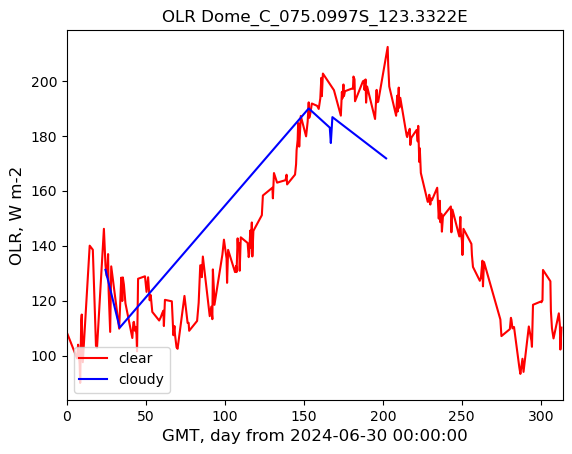

In [23]:
plot_title = out_Q+' '+POI_loc_str
img_name = out_Q+'_'+POI_loc_str+'.jpg'

plt.plot(time_series_clear[:, 0], time_series_clear[:, 1],\
         label = "clear", c = 'r')
plt.plot(time_series_cloudy[:, 0], time_series_cloudy[:, 1],
         label = "cloudy", c = 'b')

# Set the range of x-axis
l_lim = 0.
u_lim = np.ceil(max(time_series_clear[-1,0], time_series_cloudy[-1,0])) 
plt.xlim(l_lim, u_lim)

# some research is required to set the vertical range
plt.xlabel(r'GMT, day from '+dt0.strftime('%Y-%m-%d %H:%M:%S'), fontsize=12)
plt.ylabel('OLR, '+olr_unit, fontsize=12)

plt.legend(loc='lower left')

plt.title(plot_title)
plt.savefig(img_name, format='jpg', dpi=300)